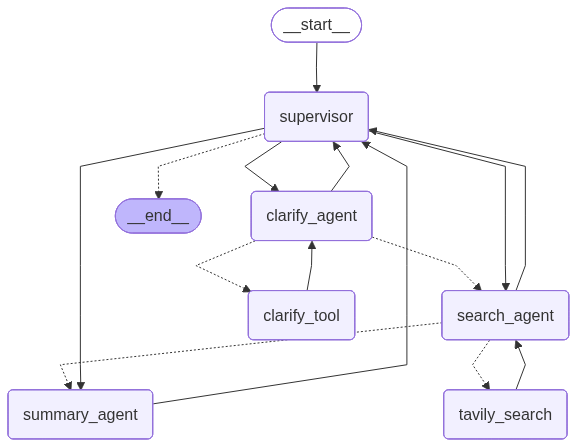

In [7]:
from typing_extensions import Annotated, Sequence, Literal, TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage, AIMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.types import Command
from langchain_deepseek import ChatDeepSeek
from langchain.tools import tool
from tavily import TavilyClient
from dotenv import load_dotenv
import os
from IPython.display import Image, display

load_dotenv()

class GlobalState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    sender: str

@tool
def tavily_search(query: str) -> dict:
    '''Search the web using Tavily'''
    tavily_api_key = os.getenv("tavily_api_key")
    client = TavilyClient(api_key=tavily_api_key)
    response = client.search(query=query)
    return response

@tool
def user_input(clarify_question: str) -> str:
    '''Get user input for clarification'''
    user_input = input(f"\n{clarify_question}\nPlease give the answer: ")
    return user_input

# Initialize models
search_model = ChatDeepSeek(model="deepseek-chat", api_key=os.getenv("api_key")).bind_tools([tavily_search])
clarify_model = ChatDeepSeek(model="deepseek-chat", api_key=os.getenv("api_key")).bind_tools([user_input])
summary_model = ChatDeepSeek(model="deepseek-chat", api_key=os.getenv("api_key"))

def clarify_agent(state: GlobalState) -> Command[Literal["clarify_tool", "search_agent", "supervisor"]]:
    """Clarification agent"""
    system_prompt = """You are a topic clarification agent. Analyze if the query is clear. 
    If not, ask clarifying questions. If clear, rephrase into a well-structured search query."""
    
    all_messages = [SystemMessage(content=system_prompt)] + state["messages"]
    response = clarify_model.invoke(all_messages)
    
    if hasattr(response, "tool_calls") and response.tool_calls:
        # Need to ask for clarification
        return Command(
            goto="clarify_tool", 
            update={"messages": all_messages + [response]}
        )
    else:
        # Query is clear, proceed to search
        return Command(
            goto="search_agent",
            update={
                "messages": [response],
                "sender": "clarify_agent"
            }
        )

def search_agent(state: GlobalState) -> Command[Literal["tavily_search", "summary_agent", "supervisor"]]:
    """Search agent"""
    system_prompt = """You are a search agent with access to web search. 
    Use the search tool to find relevant information and summarize the results."""
    
    system_message = SystemMessage(content=system_prompt)
    all_messages = [system_message] + state["messages"]
    response = search_model.invoke(all_messages)
    
    if hasattr(response, "tool_calls") and response.tool_calls:
        # Need to perform search
        return Command(
            goto="tavily_search",
            update={"messages": all_messages + [response]}
        )
    else:
        # Search completed, proceed to summary
        return Command(
            goto="summary_agent",
            update={
                "messages": [response],
                "sender": "search_agent"
            }
        )

def summary_agent(state: GlobalState) -> Command[Literal["supervisor"]]:
    """Summary agent"""
    system_prompt = """You are a summary agent. Create a concise report from all search results."""
    
    system_message = SystemMessage(content=system_prompt)
    all_messages = [system_message] + state["messages"]
    response = summary_model.invoke(all_messages)
    
    return Command(
        goto="supervisor",
        update={
            "messages": [response],
            "sender": "summary_agent"
        }
    )

def supervisor(state: GlobalState) -> Command[Literal["clarify_agent", "search_agent", "summary_agent", "__end__"]]:
    """Supervisor that routes between agents"""
    messages = state["messages"]
    sender = state.get("sender", "")
    
    print(f"Supervisor: current sender = {sender}")
    
    # Initial state - start with clarification
    if not sender or sender == "user":
        return Command(goto="clarify_agent")
    
    # After clarification, go to search
    elif sender == "clarify_agent":
        last_message = messages[-1]
        if isinstance(last_message, AIMessage) and not getattr(last_message, 'tool_calls', None):
            return Command(goto="search_agent")
        else:
            return Command(goto="clarify_agent")
    
    # After search, go to summary
    elif sender == "search_agent":
        last_message = messages[-1]
        if isinstance(last_message, AIMessage) and not getattr(last_message, 'tool_calls', None):
            return Command(goto="summary_agent")
        else:
            return Command(goto="search_agent")
    
    # After summary, end the workflow
    elif sender == "summary_agent":
        return Command(goto="__end__")
    
    # Default fallback
    return Command(goto="__end__")

# Build the main graph
workflow = StateGraph(GlobalState)

# Add all nodes
workflow.add_node("supervisor", supervisor)
workflow.add_node("clarify_agent", clarify_agent)
workflow.add_node("search_agent", search_agent)
workflow.add_node("summary_agent", summary_agent)
workflow.add_node("clarify_tool", ToolNode([user_input]))
workflow.add_node("tavily_search", ToolNode([tavily_search]))

# Set up edges
workflow.add_edge(START, "supervisor")

# Supervisor routing edges
workflow.add_edge("supervisor", "clarify_agent")
workflow.add_edge("supervisor", "search_agent")
workflow.add_edge("supervisor", "summary_agent")
workflow.add_edge("supervisor", "__end__")

# Agent completion edges (all agents return to supervisor)
workflow.add_edge("clarify_agent", "supervisor")
workflow.add_edge("search_agent", "supervisor")
workflow.add_edge("summary_agent", "supervisor")

# Tool execution edges
workflow.add_edge("clarify_tool", "clarify_agent")  # After user input, return to clarify agent
workflow.add_edge("tavily_search", "search_agent")  # After search, return to search agent

# Compile the app
app = workflow.compile()

# Display the graph
display(Image(app.get_graph().draw_mermaid_png()))

# Test function
def run_workflow(user_query: str):
    initial_state = {
        "messages": [HumanMessage(content=user_query)],
        "sender": "user"
    }
    
    print("Starting workflow...")
    final_state = app.invoke(initial_state)
    print("\n=== Final Result ===")
    print(final_state["messages"][-1].content)
    return final_state

# Test
# if __name__ == "__main__":
#     result = run_workflow("帮我搜索关于人工智能的最新发展")

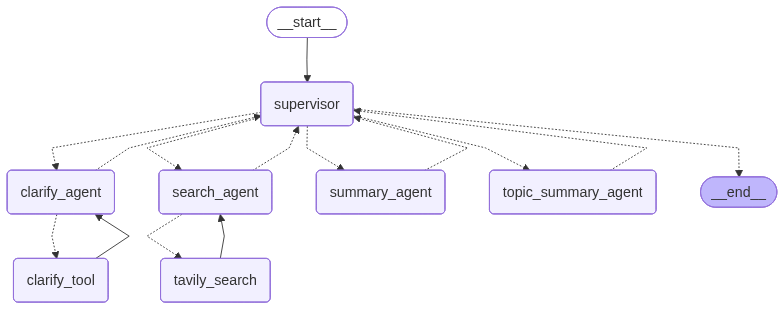

In [10]:
from typing_extensions import Annotated, Sequence, Literal, TypedDict
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage, AIMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.types import Command
from langchain_deepseek import ChatDeepSeek
from langchain.tools import tool
from tavily import TavilyClient
from dotenv import load_dotenv
import os
from concurrent.futures import ThreadPoolExecutor
from IPython.display import Image, display

load_dotenv()

class GlobalState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    sender: str

@tool
def tavily_search(queries: list[str]) -> list[dict]:
    '''
    Search the web using Tavily to find related resource from the Internet
    Args:
        queries(list[str]): summarized search queries
    Return:
        collected research result over the search queries
    '''
    tavily_api_key = os.getenv("tavily_api_key")
    client = TavilyClient(api_key=tavily_api_key)
    with ThreadPoolExecutor(max_workers=5) as executor:
        search_results = list(executor.map(lambda q: client.search(query=q), queries))
    # response = client.search(query=query)
    return search_results

@tool
def user_input(clarify_question: str) -> str:
    '''
    Get user input for clarification
    Args:
        clarify_question(str): the variable is for further clarifying the research topic
    '''
    user_input = input(f"\n{clarify_question}\nPlease give the answer: ")
    return user_input

# Initialize models
search_model = ChatDeepSeek(model="deepseek-chat", api_key=os.getenv("api_key")).bind_tools([tavily_search])
clarify_model = ChatDeepSeek(model="deepseek-chat", api_key=os.getenv("api_key")).bind_tools([user_input])
summary_model = ChatDeepSeek(model="deepseek-chat", api_key=os.getenv("api_key"))

def clarify_agent(state: GlobalState) -> Command[Literal["clarify_tool", "supervisor"]]:
    """Clarification agent - 总是返回到supervisor"""
    system_prompt = """
    You are a topic clarification agent. Analyze if the query is clear enough for web search. 
    
    CRITICAL INSTRUCTION: If the query is vague, broad, or lacks specific details, you MUST use the user_input tool to ask clarifying questions.
    
    Examples of when to use the tool:
    - Query is too broad (e.g., "AI developments")
    - Missing specific aspects (e.g., time frame, location, specific technology)
    - Need more context about user's intent
    
    Only proceed without tool usage if the query is already specific and clear enough for direct web search.
    """
    messages = state["messages"]
    if len(messages) == 1:
        all_messages = [SystemMessage(content=system_prompt)] + state["messages"][0:]
    else:
        all_messages = [SystemMessage(content=system_prompt)] + state["messages"][1:]
    response = clarify_model.invoke(all_messages)
    
    if hasattr(response, "tool_calls") and response.tool_calls:
        # Need to ask for clarification
        return Command(
            goto="clarify_tool", 
            update={"messages": [response]}
        )
    else:
        # Query is clear, 返回到supervisor让supervisor决定下一步
        return Command(
            goto="supervisor",
            update={
                "messages": [response],
                "sender": "clarify_agent"
            }
        )

def search_agent(state: GlobalState) -> Command[Literal["tavily_search", "supervisor"]]:
    """Search agent - 总是返回到supervisor"""
    system_prompt = """You are a search agent with access to web search. 
    Use the search tool to find relevant information and summarize the results."""
    messages = state["messages"]
    if len(messages) != 0 and messages[0]:
        all_messages = [SystemMessage(content=system_prompt)] + state["messages"][1:]
    else:
        all_messages = [SystemMessage(content=system_prompt)] + state["messages"]

    response = search_model.invoke(all_messages)
    
    if hasattr(response, "tool_calls") and response.tool_calls:
        # Need to perform search
        return Command(
            goto="tavily_search",
            update={"messages": all_messages + [response]}
        )
    else:
        # Search completed, 返回到supervisor让supervisor决定下一步
        return Command(
            goto="supervisor",
            update={
                "messages": [response],
                "sender": "search_agent"
            }
        )

def summary_agent(state: GlobalState) -> Command[Literal["supervisor"]]:
    """Summary agent - 总是返回到supervisor"""
    system_prompt = """You are a summary agent. Create a concise report from all search results."""
    messages = state["messages"]
    if len(messages) != 0 and messages[0]:
        all_messages = [SystemMessage(content=system_prompt)] + state["messages"][1:]
    else:
        all_messages = [SystemMessage(content=system_prompt)] + state["messages"]
    response = summary_model.invoke(all_messages)
    
    return Command(
        goto="supervisor",
        update={
            "messages": [response],
            "sender": "summary_agent"
        }
    )

def topic_summary_agent(state: GlobalState)->Command[Literal["supervisor"]]:
    '''This agent is for summerizing user's input with the clarification questions and answers into 3-4 search topic strings'''
    system_prompt = "Please summarize user's clarification conversation and initial search topic into 3 - 4 search topics for search tool"
    response = summary_model.invoke({"messages": [SystemMessage(content=system_prompt)] + state["messages"]})
    return Command(
        goto="supervisor",
        update={
            "messages": [response],
            "sender": "topic_summary_agent"
        }
    )
    

def supervisor(state: GlobalState) -> Command[Literal["clarify_agent", "search_agent", "summary_agent", "topic_summary_agent", "__end__"]]:
    """Supervisor that routes between agents"""
    messages = state["messages"]
    sender = state.get("sender", "")
    
    print(f"Supervisor: current sender = {sender}")
    
    # 初始状态 - 开始clarification
    if not sender or sender == "user":
        return Command(goto="clarify_agent")
    
    # clarify_agent完成后
    elif sender == "clarify_agent":
        last_message = messages[-1]
        # 检查是否还需要继续clarification
        if isinstance(last_message, AIMessage) and not getattr(last_message, 'tool_calls', None):
            # clarification完成，转到topic_summary_agent
            return Command(goto="topic_summary_agent")
        else:
            # 还需要继续clarification
            return Command(goto="clarify_agent")
    elif sender == "topic_summary_agent":
        return Command(goto="search_agent")
    # search_agent完成后
    elif sender == "search_agent":
        last_message = messages[-1]
        # 检查search是否完成
        if isinstance(last_message, AIMessage) and not getattr(last_message, 'tool_calls', None):
            # search完成，转到summary
            return Command(goto="summary_agent")
        else:
            # 还需要继续search
            return Command(goto="search_agent")
    
    # summary_agent完成后，结束工作流
    elif sender == "summary_agent":
        return Command(goto="__end__")
    
    # 默认fallback
    return Command(goto="__end__")

# Build the main graph
workflow = StateGraph(GlobalState)

# Add all nodes
workflow.add_node("supervisor", supervisor)
workflow.add_node("clarify_agent", clarify_agent)
workflow.add_node("search_agent", search_agent)
workflow.add_node("summary_agent", summary_agent)
workflow.add_node("topic_summary_agent", topic_summary_agent)
workflow.add_node("clarify_tool", ToolNode([user_input]))
workflow.add_node("tavily_search", ToolNode([tavily_search]))

# Set up edges
workflow.add_edge(START, "supervisor")

# Supervisor routing edges - supervisor决定下一步去哪里
# workflow.add_edge("supervisor", "clarify_agent")
# workflow.add_edge("supervisor", "search_agent")
# workflow.add_edge("supervisor", "summary_agent")
workflow.add_edge("supervisor", "__end__")

# Agent completion edges - 所有agent完成后都返回到supervisor
# workflow.add_edge("clarify_agent", "supervisor")
# workflow.add_edge("search_agent", "supervisor")
# workflow.add_edge("summary_agent", "supervisor")

# Tool execution edges - 工具执行后回到对应的agent
workflow.add_edge("clarify_tool", "clarify_agent")  # user input后回到clarify agent
workflow.add_edge("tavily_search", "search_agent")  # search后回到search agent

# Compile the app
app = workflow.compile()

# Display the graph
display(Image(app.get_graph().draw_mermaid_png()))

# Test function
def run_workflow(user_query: str):
    initial_state = {
        "messages": [HumanMessage(content=user_query)],
        "sender": "user"
    }
    
    print("Starting workflow...")
    for step in app.stream(initial_state, stream_mode="updates"):
        print(step)
    # final_state = app.invoke(initial_state)


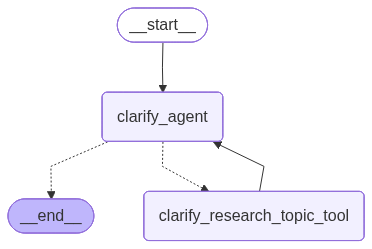

In [17]:
from typing import Sequence, TypedDict, Annotated, Literal
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage, BaseMessage
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langchain.tools import tool
from langchain_deepseek import ChatDeepSeek
from langgraph.types import Command
from langgraph.prebuilt import ToolNode
import os

class Clarify_State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    sender: str

@tool
def clarify_research_topic(question: str)->str:
    '''
    This is a tool function that will take question generated by AI and take user's answer as return
    Args:
        question(str): the question str as clarification question
    Return:
        user_input(str): the feedback from user about the question
    '''
    print(question)
    feedback = input("What is your answer:")
    return feedback

model = ChatDeepSeek(model="deepseek-chat", api_key=os.getenv("api_key")).bind_tools([clarify_research_topic])

def clarify_agent(state: Clarify_State)->Command[Literal["__end__", "clarify_research_topic_tool"]]:
    '''The clarify agent will take user's question and clarify it via using tool for taking user's feedback is the question is not clear or too big to analyze'''
    system_prompt = "The clarify agent is for clarifying user's prompt for more details such as when, what or asking for a specific domain / aspect if not clear enough. You can use the clarify_research_topic tool"
    system_message = SystemMessage(content=system_prompt)
    all_messages = [system_message] + state["messages"]
    response = model.invoke(all_messages)
    if hasattr(response, "tool_calls"):
        return Command(
            goto="clarify_research_topic_tool",
            update={"messages": state["messages"] + [response], "sender": "clarify_agent"}
        )
    else:
        return Command(goto="__end__")

clarify_app_graph = StateGraph(Clarify_State)
clarify_app_graph.add_node("clarify_agent", clarify_agent)
clarify_app_graph.add_node("clarify_research_topic_tool", ToolNode([clarify_research_topic]))
clarify_app_graph.add_edge(START, "clarify_agent")
clarify_app_graph.add_edge("clarify_research_topic_tool", "clarify_agent")
clarify_app = clarify_app_graph.compile()




from IPython.display import Image, display
display(Image(clarify_app.get_graph().draw_mermaid_png()))


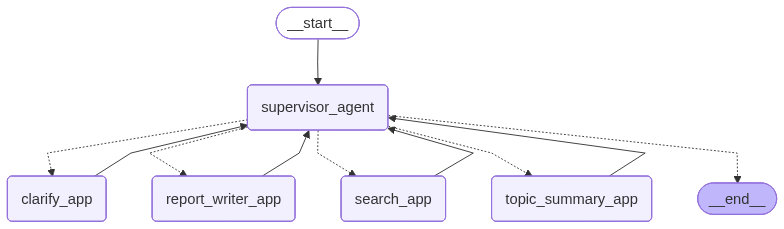

In [22]:
from typing import Sequence, TypedDict, Annotated, Literal, List
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage, BaseMessage
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langchain.tools import tool
from langchain_deepseek import ChatDeepSeek
from langgraph.types import Command
from langgraph.prebuilt import ToolNode
from pydantic import BaseModel
from concurrent.futures import ThreadPoolExecutor
from tavily import TavilyClient
import os

class Clarify_State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    sender: str

@tool
def clarify_research_topic(question: str)->str:
    '''
    This is a tool function that will take question generated by AI and take user's answer as return
    Args:
        question(str): the question str as clarification question
    Return:
        user_input(str): the feedback from user about the question
    '''
    print(question)
    feedback = input("What is your answer:")
    return feedback

topic_clarify_model = ChatDeepSeek(model="deepseek-chat", api_key=os.getenv("api_key")).bind_tools([clarify_research_topic])

def clarify_agent(state: Clarify_State)->Command[Literal["__end__", "clarify_research_topic_tool"]]:
    '''The clarify agent will take user's question and clarify it via using tool for taking user's feedback is the question is not clear or too big to analyze'''
    system_prompt = """
    You are a topic clarification agent. Analyze if the query is clear enough for web search. 
    
    CRITICAL INSTRUCTION: If the query is vague, broad, or lacks specific details, you MUST use the clarify_research_topic tool to ask clarifying questions.
    
    Examples of when to use the tool:
    - Query is too broad (e.g., "AI developments")
    - Missing specific aspects (e.g., time frame, location, specific technology)
    - Need more context about user's intent
    
    Only proceed without tool usage if the query is already specific and clear enough for direct web search.
    """
    system_message = SystemMessage(content=system_prompt)
    all_messages = [system_message] + state["messages"]
    response = topic_clarify_model.invoke(all_messages)
    if hasattr(response, "tool_calls") and len(response.tool_calls) > 0:
        return Command(
            goto="clarify_research_topic_tool",
            update={"messages": state["messages"] + [response], "sender": "clarify_agent"}
        )
    else:
        return Command(goto="__end__")
    


class Topics(BaseModel):
    topics: List[str]

class Summary_State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    summarized_topics: Sequence[str]
    sender: str

topic_summary_model = ChatDeepSeek(model="deepseek-chat", api_key=os.getenv("api_key")).with_structured_output(Topics)

def topic_summary_agent(state: Summary_State)->Command[Literal["__end__"]]:
    '''
    this topic summary agent is responsible for summarizing the the conversation with user's input into 3 - 4 key topics
    '''
    system_prompt = "This is topic summary agent. For summarizing the conversation into 3 - 4 key topics which will be used for other search agent to process"
    all_messages = [SystemMessage(content=system_prompt)] + state['messages']
    response = topic_summary_model.invoke(all_messages)
    return Command (
        goto="__end__",
        update={
            "messages": state["messages"] + [response],
            "summarized_topics": response.text,
            "sender": "topic_summary_agent"
        }
    )

@tool
def search_tool(topics: List[str])->list[dict]:
    '''
    search_tool is for finding the relevant information over the internet via the tavily client
    Args:
        topics(List[str]): the list of search topics that the search tool will need to search the relevant information
    Return:
        a list of dict of the information of each topics
    '''
    tavily_api_key = os.getenv("tavily_api_key")
    client = TavilyClient(api_key=tavily_api_key)
    with ThreadPoolExecutor(max_workers=5) as executor:
        results = list(executor.map(lambda topic: client.search(topic), topics))
    return results

class Search_State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    search_count: int

search_model = ChatDeepSeek(model="deepseek-chat", api_key=os.getenv("api_key")).bind_tools([search_tool])

def search_agent(state: Search_State)->Command[Literal["search_tool", "__end__"]]:
    '''This search agent will search the relevant information about the search topics via the search tool I provide'''
    system_prompt = "search agent will be using the search tool for fidning the relevant information from the internet." \
    "for search the information you MUST use the search tool I provide"
    
    all_messages = [SystemMessage(content=system_prompt)] + state["messages"]
    response = search_model.invoke(all_messages)
    if hasattr(response, "tool_calls"):
        return Command(
            goto="search_tool",
            update={
                "messages": state["messages"] + [response],
                "search_count": state.get("search_count", 0) + 1
            }
        )

class Report_Writer_State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    sender: str

report_writer_model = ChatDeepSeek(model="deepseek-chat", api_key=os.getenv("api_key"))

def report_writer_agent(state: Report_Writer_State) -> Command[Literal["__end__"]]:
    '''
    The report write agent is for summarizing the search results into a small report
    '''
    system_prompt = "You are professional report writer good at summarizing the previous conversation and search result into a formal report. " \
    "Please make sure you can complete the task and DONT add any fake information there, unless it is a educated guess"
    system_message = SystemMessage(content=system_prompt)
    all_messages = [system_message] + state["messages"]
    response = report_writer_model.invoke(all_messages)
    return Command(
        goto="__end__",
        update={
            "messages": state["messages"] + [response],
            "sender": "report_writer_agent"
        }
    )

    

class Supervisor_State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    sender: str

def supervisor_agent(state: Supervisor_State)->Command[Literal["clarify_app", "topic_summary_app", "search_app", "report_writer_app"]]:
    '''supervise agent is for routing the message states between different sub-agents for completing the deligated tasks'''
    if state["sender"] == "user":
        return Command(goto="clarify_app", update={
            "messages": state["messages"],
            "sender": "supervisor_agent"
        })
    elif state["sender"] == "clarify_agent":
        return Command(goto="topic_summary_app", update={
            "messages": state["messages"],
            "sender": "supervisor_agent"
        })
    elif state["sender"] == "topic_summary_agent":
        return Command(goto="search_app", update={
            "messages": state["messages"],
            "sender":"supervisor_agent"
        })
    elif state["sender"] == "search_agent":
        return Command(goto="report_writer_app", update={
            "messages": state["messages"],
            "sender": "supervisor_agent"
        })
    elif state["sender"] == "report_writer_agent":
        return Command(goto="__end__", update={
            "messages": state["messages"],
            "sender": "supervisor_agent"
        })
        

topic_summary_app_graph = StateGraph(Summary_State)
topic_summary_app_graph.add_node("topic_summary_agent", topic_summary_agent)
topic_summary_app_graph.add_edge(START, "topic_summary_agent")
topic_summary_app = topic_summary_app_graph.compile()


report_writer_app_graph = StateGraph(Report_Writer_State)
report_writer_app_graph.add_node("report_writer_agent", report_writer_agent)
report_writer_app_graph.add_edge(START, "report_writer_agent")
report_writer_app = report_writer_app_graph.compile()
    

clarify_app_graph = StateGraph(Clarify_State)
clarify_app_graph.add_node("clarify_agent", clarify_agent)
clarify_app_graph.add_node("clarify_research_topic_tool", ToolNode([clarify_research_topic]))
clarify_app_graph.add_edge(START, "clarify_agent")
clarify_app_graph.add_edge("clarify_research_topic_tool", "clarify_agent")
clarify_app = clarify_app_graph.compile()


search_app_graph = StateGraph(Search_State)
search_app_graph.add_node("search_agent", search_agent)
search_app_graph.add_node("search_tool", ToolNode(tools=[search_tool]))
search_app_graph.add_edge(START, "search_agent")
search_app_graph.add_edge("search_tool", "search_agent")
search_app = search_app_graph.compile()

supervisor_app_graph = StateGraph(Supervisor_State)
supervisor_app_graph.add_node("supervisor_agent", supervisor_agent)
supervisor_app_graph.add_node("clarify_app", clarify_app)
supervisor_app_graph.add_node("topic_summary_app", topic_summary_app)
supervisor_app_graph.add_node("search_app", search_app)
supervisor_app_graph.add_node("report_writer_app", report_writer_app)
supervisor_app_graph.add_edge(START, "supervisor_agent")
supervisor_app_graph.add_edge("clarify_app", "supervisor_agent")
supervisor_app_graph.add_edge("topic_summary_app", "supervisor_agent")
supervisor_app_graph.add_edge("search_app", "supervisor_agent")
supervisor_app_graph.add_edge("report_writer_app", "supervisor_agent")
supervisor_app = supervisor_app_graph.compile()


#supervisor_app.invoke({"messages": [HumanMessage(content="can you give me some AI related information ?")], "sender": "user"})

from IPython.display import display, Image

display(Image(supervisor_app.get_graph().draw_mermaid_png()))
 